# Pick the right hashtag

Social media has fundamentally changed the way in which we interact with each other, and with the world wide web. Our web activities are now inherently social. We can keep in touch with close friends on facebook without ever needing to pick up a phone or get on a train. We can use twitter to share our thoughts with the world, and we can explore someone else's by scrolling through pinterest boards, but at the same time the social web is diffuse, sprawling and unorganized. Hashtags represent one way to help keep the social web together and somewhat organized.

In general, hashtags are simple phrases or words that are preceded by a pound sign (#), and they serve the purpose of tagging a picture, post or message as being related to a specific or popular topic. They help broadcast information in a way that puts it within reach of a wider audience, and, if used correctly, they can help grow our digital social circles. But how should I pick the best hashtag? The best hashtags are the ones that are most relevant to the post and the ones that will reach largest number of viewers. In this post, we explore one way to pick the "best" hashtag(s) for your tweets, using python and a little network analysis.

To start, lets think about sending out a tweet about a really cool new data science article. I could just use the #datascience hashtag, but lets take a closer look at what the available options are. To do that, we will use a weeks worth of data science related tweets that were collected for a previous post, and visualize hashtag frequency using <a href=https://github.com/amueller/word_cloud>wordcloud</a>, a very nice python library for plotting word clouds.

First, let's load in our tweets and extract hashtags from all of the postings.

In [1]:
import sys
import warnings
import json
import dateutil
import datetime
import numpy as np
import pandas as pd
from os import path
from datetime import timedelta

def get_tags(text):
    '''Return unique lists of hashtags from twitter text, by splitting text
    and returing unique strings that start with #'''
    tags = list( set(tag for tag in text.split() if tag.startswith('#')) )
    to_remove="$:;,.?!/\\*%@#"
    return map(lambda x: ''.join( c for c in x if  c not in to_remove ),tags)

tags = []
verbose=False
for i in open("data_science_twitter.txt", 'r').readlines():
    if i=="\n":
        next
    else:
        try:
            data = json.JSONDecoder().raw_decode(i)
            hash = list(data)[0]
            text = hash["text"].rstrip('\n\r') # remove newline characters
            clean_text = text.encode("ascii","ignore") # removes unicode
            date = dateutil.parser.parse(hash["created_at"])
            tags.append([map(lambda x:x.upper(),get_tags(clean_text)),date]) # make hashtags uppercase to avoid case-senstive duplications
        except:
            if verbose==True: print "No useable data on this line:", hash
            continue

tags.sort(key=lambda l_t: l_t[1]) # make sure the data are date sorted, otherwise searching will be not be fast

tags_df = pd.DataFrame(tags)
tags_df.columns = ['text', 'date']
tags_df = tags_df.set_index('date')

In [2]:
def flatten(x):
    return [item for sublist in x for item in sublist]

tag_text = flatten(tags_df["text"].values.tolist())

Once the tweets have been loaded and hashtags extracted, let's go ahead and plot them using wordcloud. The wordcloud library gives the user the option to define custom coloring functions, and it allows the use of custom images for image masking and plotting. For this example, I will make a function to randomly select one of three red colors and use a web-image of a cartoon brain as a image mask.

(-0.5, 1999.5, 1999.5, -0.5)

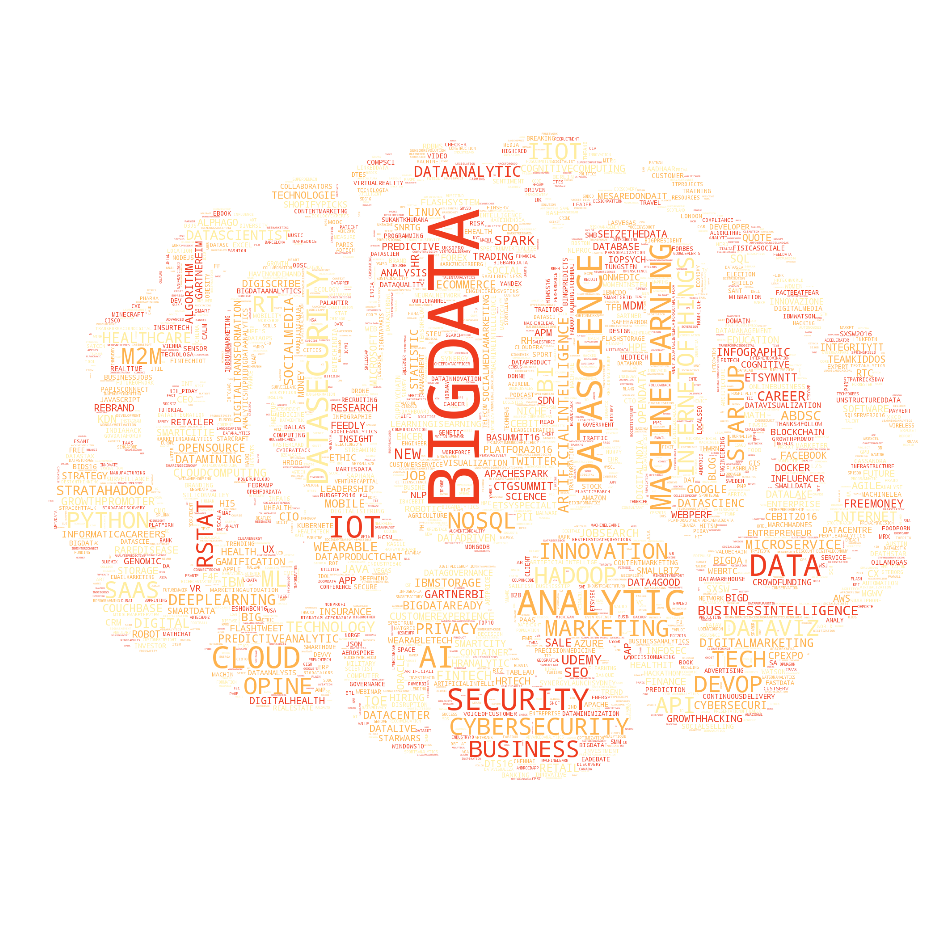

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.misc import imread

def red_col(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(['hsl(49, 100%, 81%)', 'hsl(34, 99%, 65%)', 'hsl(8, 87%, 53%)'])

cloud_mask = imread("brain.png")
image_colors = ImageColorGenerator(cloud_mask)
wc = WordCloud(background_color="white", max_words=2000, mask=cloud_mask)
wordcloud = wc.generate(" ".join(tag_text))
plt.figure(figsize=(16,16))
plt.imshow(wc.recolor(color_func=red_col))
plt.axis("off")

The size of the text is a proxy for its frequency. As we can see, there are a large number of hashtags in data science related tweets, but "BIGDATA", "ANALYTIC" and "DATASCIENCE" stand out as being most popular. However, there are several other popular tweets used over the course of the week. Let's take a look at the top 10 based on number of occurrence.

In [4]:
total_word_count=[]
for i in set(tag_text):
    total_word_count.append((i,tag_text.count(i)))

In [5]:
number = 10
top_all = dict(sorted(total_word_count, key=lambda x: x[1])[-number:])

for i in top_all.keys():
    print "The %s hashtag was seen about %d times" % (i,top_all[i])

The MACHINELEARNING hashtag was seen about 15211 times
The DATASECURITY hashtag was seen about 2673 times
The AI hashtag was seen about 3461 times
The IOT hashtag was seen about 13503 times
The BIGDATA hashtag was seen about 115575 times
The ANALYTICS hashtag was seen about 16333 times
The SECURITY hashtag was seen about 3518 times
The DATA hashtag was seen about 5681 times
The DATASCIENCE hashtag was seen about 24589 times
The CLOUD hashtag was seen about 3645 times


The "BIGDATA" hashtag was seen over 100,000 times. Impressive. Should I simply pick a random sampling from the top 10 hashtags and be on my way? It might not be a terrible strategy, but there is a better one. Twitter is a highly dynamic platform where the top hashtag(s) can change within the hour and even from minute to minute. As a simple exploration of this notion, let's break our weeks work of tweets into hour increments and plot the rank of the top 10 hashtags relative to each other.

The result, of course, will be much simpler than what actually happens on twitter, as we will only see what happens to the weekly top 10 with respects to each other. We will not, for example, be able to see any hashtags that rise into the top 10 in each individual time period.

To start, we will iterate through each hour and look to see what the relative ranks among to weekly top 10 hashtags are.


In [6]:
def get_time_groups(df, sec):
    '''Find groups of hashtags in 60 second windows.'''
    time_now = datetime.datetime.now()
    start = df.index.searchsorted(time_now - timedelta(seconds=sec))
    end = df.index.searchsorted(time_now)
    return df.ix[start:end]

In [7]:
top_rank = {}
for i in top_all.keys():
    top_rank[i] = []

start = tags_df.index.searchsorted(datetime.datetime.utcfromtimestamp(tags_df.ix[0:1].index.values.tolist()[0]/1e9))
end = 0

while end < len(tags_df.index):
    end = tags_df.index.searchsorted(datetime.datetime.utcfromtimestamp(
            tags_df.ix[start:start+1].index.values.tolist()[0]/1e9) + 
            timedelta(seconds=3600))
    
    new_df = tags_df.ix[start:end]
    hash_list = flatten(new_df["text"].values.tolist())

    hash_list_counts =  dict([(x,hash_list.count(x)) for x in set(hash_list)])
    raw_counts = [(x,hash_list_counts[x]) if x in hash_list_counts.keys() 
                   else (x,0) for x in top_rank.keys()]
    
    ranks = zip(range(1,len(raw_counts)+1),sorted(raw_counts,key=lambda x: x[1])[::-1])

    for i in ranks:
        top_rank[i[1][0]].append(i[0])

    start = end

After gathering the relative ranks for each hour, we will plot them using <a href="https://plot.ly/">plotly</a>.

In [8]:
import plotly
from plotly.graph_objs import *#Scatter, Layout

plotly.offline.init_notebook_mode()

def data_plot(rank_dict):
    container = []

    for i in rank_dict.keys():
        ranks = rank_dict[i]
        container.append(Scatter(x=range(1,len(ranks)),y=ranks,name=i))
        
    layout= dict(
        xaxis = dict(title = 'Hour'),
        yaxis = dict(title = 'Relative Rank',autorange='reversed'),
        legend=dict(
          y=0.5,
          font=dict(size=12)))

    return (container,layout)

data,layout=data_plot(top_rank)
fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

What we can see is that the "BIGDATA" hashtag is reliably the top tag among the 10, even in hourly increments, but we also see that the relative rank of all of the other top 10 tags varies from hour to hour. This suggests that in order to maximize the utility of our hashtag, what we really need is a real-time indicator, but the same time we want to limit the number of hashtags that we use. Twitter only allows the use of 140 characters.

To satisfy both of these goals, we can use <a href="http://www.tweepy.org/">tweepy</a> to collect tweets in real time and use <a href="https://networkx.github.io/">NetworkX</a> to build a hashtag network in order to find the most influential hashtags within a specified time window. Once hashtag networks are built, eigenvector centrality will be used as a way to rank and plot hashtags according to their influence in real-time. Using a centrality measure to pick hashtags essentially gives us the ability to use one or two hashtags while still gaining the viewership that would be equivalent of overloading our tweet with several tags. Choosing a hashtag based on a simple frequency value does not always offer this same value.

In [ ]:
import networkx as nx
import itertools
import re
from IPython import display
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

def blu_col(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(['hsl(107, 50%, 91%)', 'hsl(135, 44%, 76%)', 'hsl(198, 56%, 53%)','hsl(198, 56%, 53%)'])

def create_graph(list_of_lists):
    '''given a list conprising of lists of hashtags, construct a graph.
    If the list is greater than 2 or more, make sure to create all possible
    edges given the hashtag combination.  If the list is 0, do nothing and 
    if it is of size 1 then just create a node.'''
    
    G=nx.Graph()    
    for i in list_of_lists:
        if len(i)>1:
            G.add_edges_from(list(itertools.combinations(i,2)))
        elif len(i)==0:
            continue
        elif len(i)==1:
            G.add_node(*i)
    return G

class StdOutListener(StreamListener):
    def on_data(self, data):
        out = []
        verbose=False
        try:
            data = json.JSONDecoder().raw_decode(data)
            hash = list(data)[0]
            text = hash["text"].rstrip('\n\r') # remove newline characters
            clean_text = text.encode("ascii","ignore") # removes unicode
            date = datetime.datetime.now()
            out.append([map(lambda x:x.upper(),get_tags(clean_text)),date]) # make hashtags uppercase to avoid case-senstive duplications
        except:
            if verbose==True: print "No useable data on this line:", hash

        out.sort(key=lambda l_t: l_t[1]) # make sure the data are date sorted, otherwise searching will be not be fast

        if 's_t' not in globals():
            global s_t
            s_t = pd.DataFrame(out)
            s_t.columns = ['text', 'date']
            s_t = s_t.set_index('date')
        else:
            global s_t
            s_t_2 = pd.DataFrame(out)
            s_t_2.columns = ['text', 'date']
            s_t_2 = s_t_2.set_index('date')
            s_t = pd.concat([s_t,s_t_2])
        
        g =  create_graph(get_time_groups(s_t,120)["text"].values.tolist())
        to_prune = nx.isolates(g) # find isolate nodes
        g.remove_nodes_from(to_prune) # remove isolate nodes
        
        if nx.number_of_nodes(g) == 0: # if empty graph, keep listening
            return True
        try: # try to compute centrailty, if no convergence, move on
            ev_cent=nx.eigenvector_centrality(g,max_iter=10000) # compute eigenvector centrality
        except:
            return True
            
        ev_tuple = []
        for i in ev_cent.keys():
            ev_tuple.append((i.replace("#", ""),ev_cent[i]))
            
        global time
        
        if (datetime.datetime.now() - time) > timedelta(seconds=1): # allow refresh every ~x seconds, if tweets come in
            cloud_mask = imread("tweet.png")
            image_colors = ImageColorGenerator(cloud_mask)
            wc = WordCloud(background_color="white", max_words=2000, mask=cloud_mask)
            wordcloud = wc.generate_from_frequencies(ev_tuple)#text)
            plt.figure(figsize=(12,12))
            plt.imshow(wc.recolor(color_func=blu_col))
            plt.axis("off")
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time  = datetime.datetime.now()
            
        return True        

        def on_error(self, status):
            print status

In [ ]:
consumer_key = '[your customer key here]'
consumer_secret = '[your consumer secret here]'
access_token = '[your access token here]'
access_token_secret = '[your access token secret here]'

if 's_t' in globals():
    del(s_t)

time = datetime.datetime.now()
l = StdOutListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
stream = Stream(auth, l)
stream.filter(track=['data science', 'big data', 'machine learning'])

<img src="twitter_snapshots.png">

<br>
The result is a wordcloud plot that updates in real-time based on incoming tweets. The plot makes clear what the best hashtags are. For instance, in the figure above, I have pasted together several snapshots taken over the course of the day, and it looks like the best tweet varies from time to time! The plot above is comprised of snapshots of data science tweets over a 2 minute period of time. As we can see, many of the top weekly hashtags are still important, but many other time-sensitive tags make an appearance.

# Concluding remarks

Hashtags are a powerful way to reach a broad audence and to contribute to larger discussions on twitter and other social media platforms. Indeed, a strong social media presence can really make or break a digital push for many consumer facing companies. Digital and social media marketing arms of most companies thrive on consumer interactions on twitter and other sites, and efficient hashtag choice can really improve visibility in the short and long term for digital brands. Using python, tweepy, NetworkX and wordcloud, we were able in a very simply way to develop a method for picking the best hashtag using network analysis and wordcloud visualizations.